# Aim
Choosing countries for NGO funding, which are in the direst need of aid, based on socio-economic and health factors 
that determine the overall development of the country. 


### Solution:
We will use unsupervised machine learning - "clustering" for segmenting the countries into aided and non-aided, in the above problem statement. 

### Steps: 
- Data Quality Check
- EDA: Univariate / Bivariate Analysis
- Outlier Treatment
- Check the cluster tendancy: Hopkin's Test
- Scaling
- Find the best value of k: SSD, Silhoutte Score
- Using the final value of k, perform final KMeans Analysis
- Visualize the cluster using a scatter plots
- Perform Cluster profiling: GDPP, CHILD_MORT, and INCOME
- Hierarchial Clustering:
    - Single Linkage: Dendrogram
    - Complete Linkage: Dendrogram
    - Use one of them for the final clusters
    - Visualize using the box plot
    - Perform Cluster profiling: GDPP, CHILD_MORT, and INCOME



#### Importing all required libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Scale
from sklearn.preprocessing import StandardScaler

# KMeans Clustering
from sklearn.cluster import KMeans

# Hierarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#### Reading and understanding the data:

In [2]:
#reading the file
country_details = pd.read_csv("Country-data.csv")
country_details.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
country_details.shape

(167, 10)

In [4]:
country_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


#### Data Quality Check

In [5]:
## Convert columns: exports, imports & health spending percentage to absolute values

country_details ['exports'] = country_details ['exports'] * country_details ['gdpp']/100
country_details ['health'] = country_details ['health'] * country_details ['gdpp']/100
country_details ['imports'] = country_details ['imports'] * country_details ['gdpp']/100

In [6]:
country_details.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### EDA

In [7]:
#checking for duplicates
country_details.duplicated(subset = ['country'], keep = False).sum()

0

In [8]:
# Checking for null values in the column
country_details.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [9]:
#checking if any columns having unique value ie only 1 value
unique =country_details.nunique()
unique = unique[unique.values ==1]
unique

Series([], dtype: int64)

No unique value

In [10]:
#Looking for spelling mistakes
print(country_details['country'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kiribati'
 'Kuwait' 'Kyrgyz Republic' 'Lao' 'Latvia' 'Lebanon' 'Lesotho' 'Liberia'
 '

There is no spelling mistake.

In [11]:
# Separate Categorical and Numerical variables
num_cols = country_details.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = country_details.select_dtypes(exclude=['int64','float64']).columns.tolist()
display("\n=============Numerical cols==== :\n ",num_cols)
display("\n=============Categorical cols===== : \n",cat_cols)

'\n=============Numerical cols==== :\n '

['child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

'\n=============Categorical cols===== : \n'

['country']

# Univariate Analysis of Numerical cols

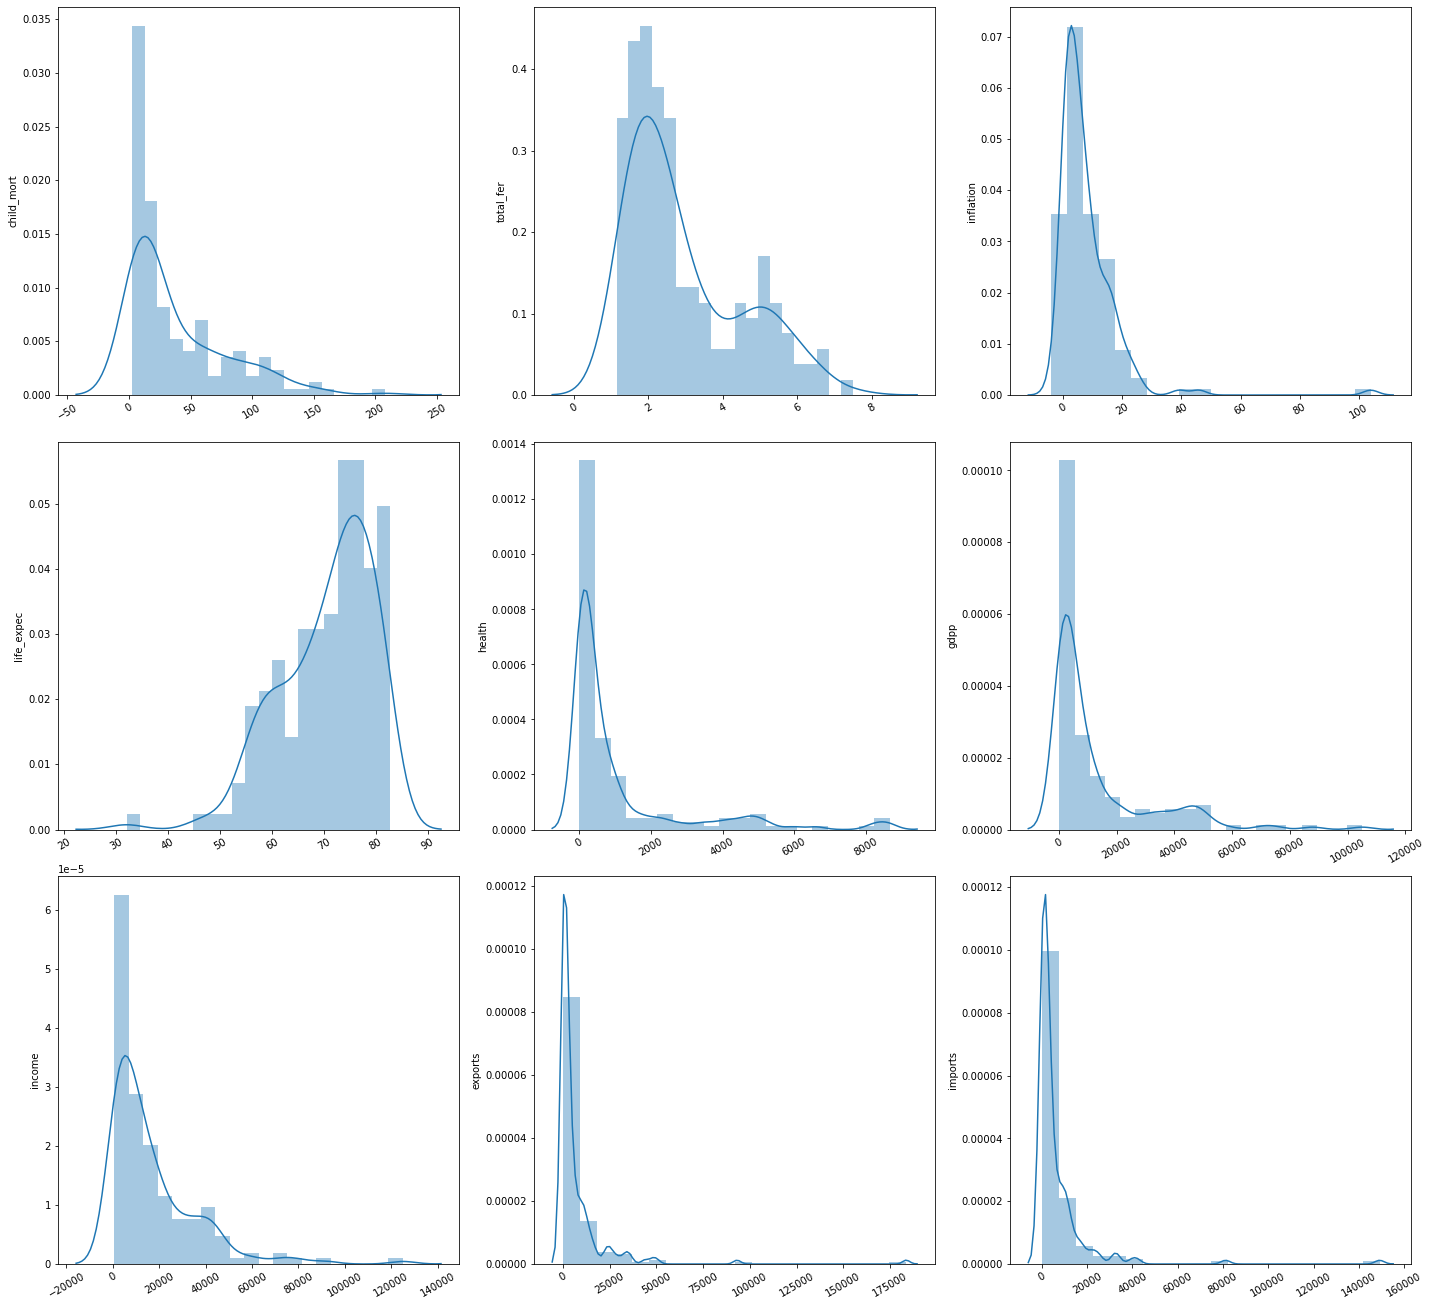

In [12]:
# Find the countries with highest: Child Mortality Rate,Fertility Rate, Inflation
# Find the countries with lowest: Life Expectancy, Health, GDP,Income,Imports,Exports
cols=['child_mort','total_fer','inflation','life_expec','health','gdpp','income','exports','imports']

# Bin the data and plot the dist plot of the numerical terms
plt.figure(figsize=(20, 60))
i=1
sortAsc=False
for c in cols:
    ax2 = plt.subplot(10,3,i)
    if(i>3):
        sortAsc = True
    top10_df = country_details[['country',c]].sort_values(c, ascending = sortAsc).head(20)
#     sns.barplot(x='country', y=c, data= top10_df, ax = ax2)
    sns.distplot(country_details[c],bins = 20, ax=ax2)
    ax2.set(xlabel=None, ylabel=c)
    plt.xticks(rotation=30)
    i = i + 1

plt.tight_layout()
plt.show()

### Observation: 
- Most of the data point are <b>not normally</b> distributed. 
- They have <b>different variance</b>. 
- They have <b>different range</b> which indicates that we will have to standardize/normalize the columns. 

## Bivariate Analysis - Numerical Vs Numerical

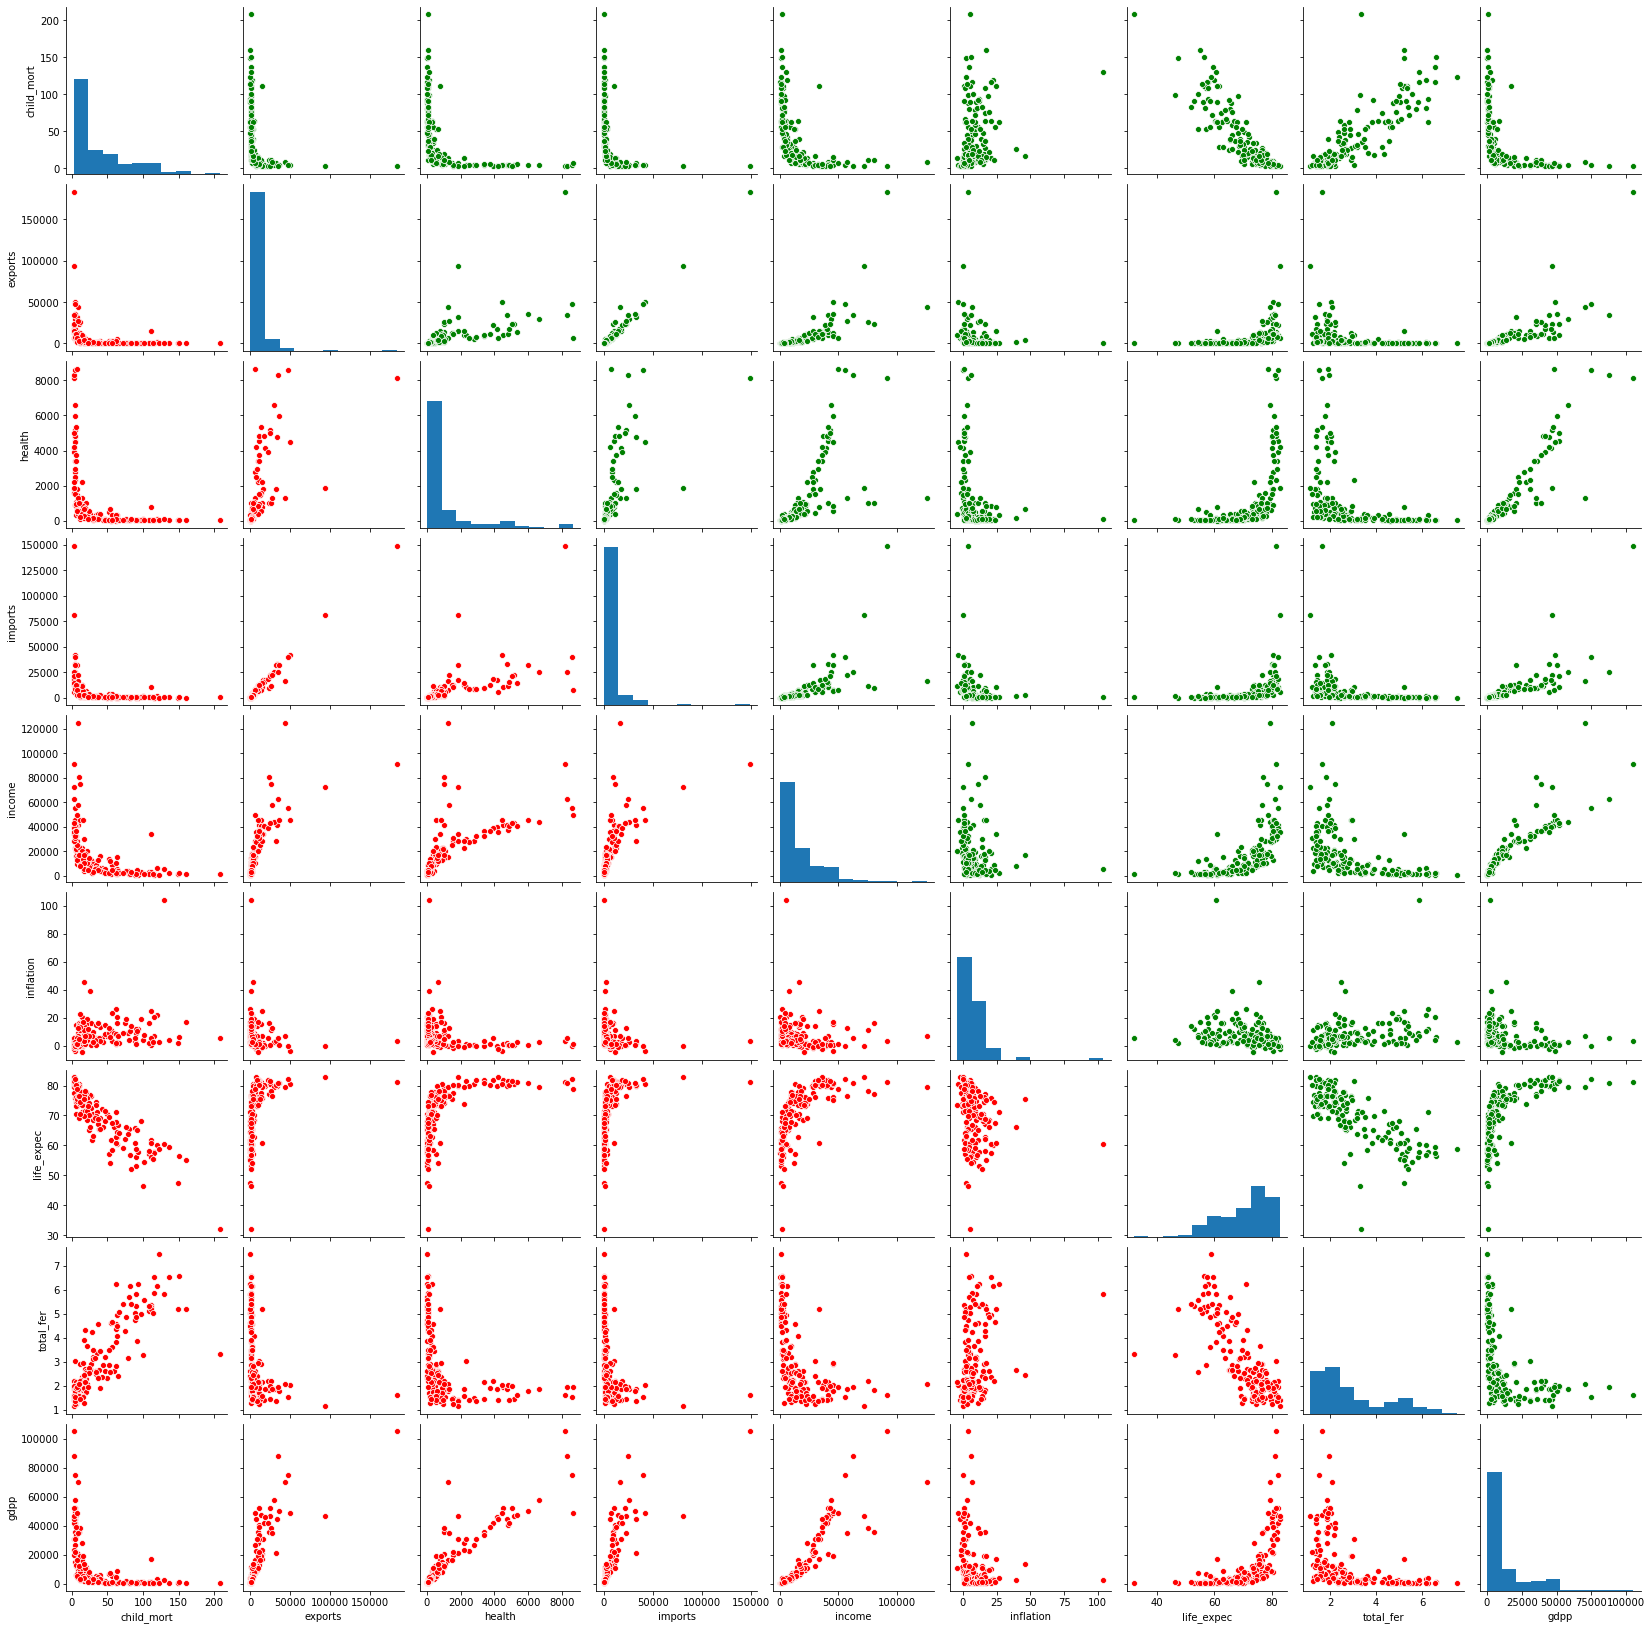

In [13]:
# pairplot of numerical variables
# sns.pairplot(data, vars=num_cols)
fig = sns.PairGrid(country_details[num_cols])
fig.map_upper(sns.scatterplot,color='green')
fig.map_lower(sns.scatterplot, color='red')
fig.map_diag(plt.hist)
plt.show()

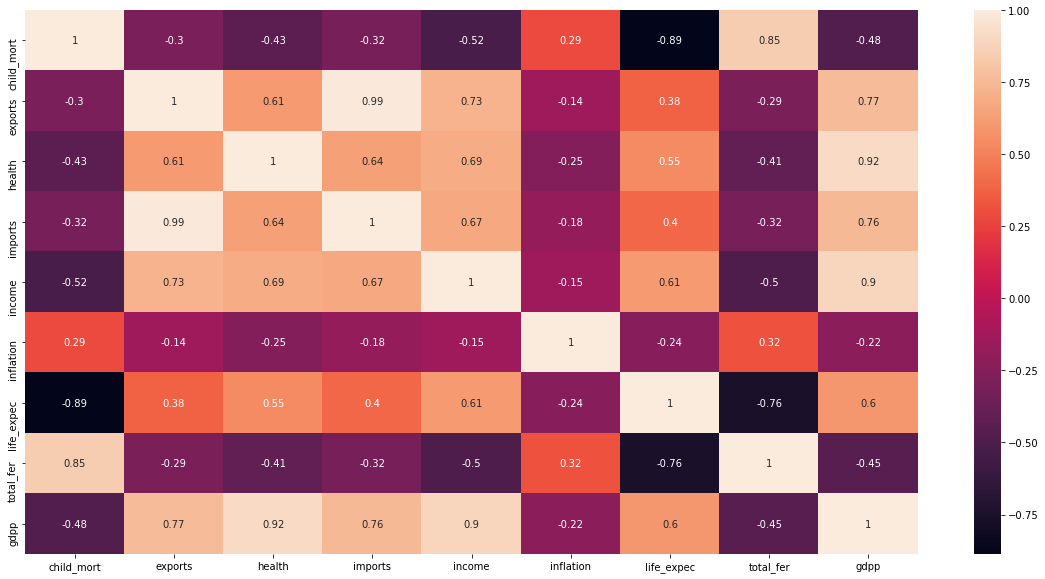

In [14]:
#so this data seems largely clean,but we have a lot of variables and making and visualising proper clusters will be a difficulty.
#first let's plot the correlation matrix and check if the data is indeed highly correlated

plt.figure(figsize = (20,10))        
sns.heatmap(country_details.corr(),annot = True)

## Observation:
### We see high correlation between `total_fer` and `child_mort`, between `gdpp` and `income`,and between `imports` and `exports`

### After data cleaning , we capped lower range  outlier of CHILD_MORT, INFLATION, TOTAL_FERTI. Moreover, capped upper range outliers for other columns. 

### We did standardized scaling to standardize all parameters on cleaned, outlier removed data


### Outlier Treatment

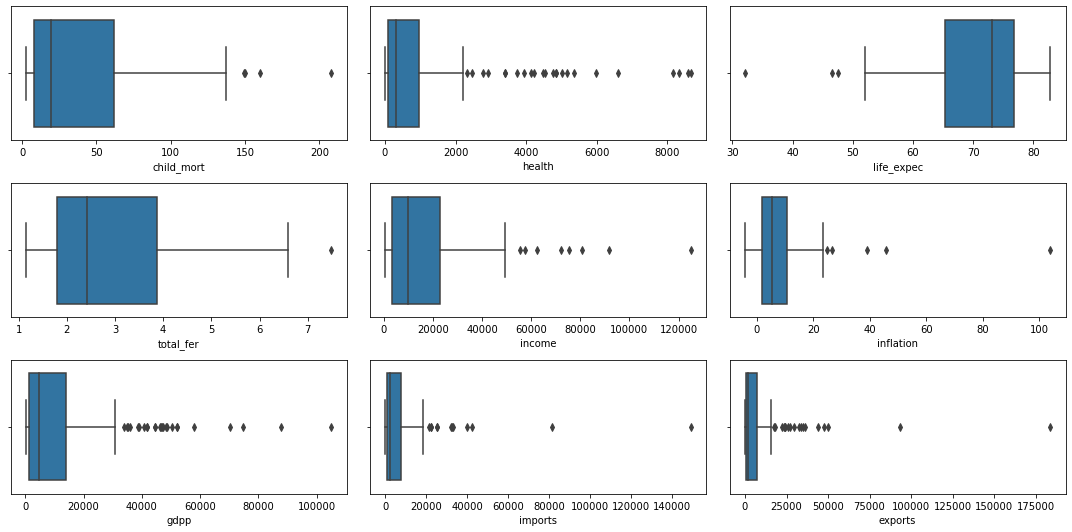

In [15]:
# Plot boxplot before capping
fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(country_details['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(country_details['health'], ax = axs[0,1])
plt3 = sns.boxplot(country_details['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(country_details['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(country_details['income'], ax = axs[1,1])
plt6 = sns.boxplot(country_details['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(country_details['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(country_details['imports'], ax = axs[2,1])
plt9 = sns.boxplot(country_details['exports'], ax = axs[2,2])
plt.tight_layout()

In [16]:
# Before manipulating data, we will save one copy of orignal data.
# data_help = country_details.copy()
# country_details.head()

### For columns such as CHILD_MORT, INFLATION, TOTAL_FERTI, doesnt do anything to the upper range outliers, but deal with the lower range outliers (capping).
### For rest of the columns, not doing anything with the lower range outliers but deal with the upper range outliers (capping).

In [17]:
# export:
percentiles = country_details['exports'].quantile([0.05,0.95]).values
country_details['exports'][country_details['exports'] <= percentiles[0]] = percentiles[0]
country_details['exports'][country_details['exports'] >= percentiles[1]] = percentiles[1]

In [18]:
percentiles = country_details['imports'].quantile([0.05,0.95]).values
country_details['imports'][country_details['imports'] <= percentiles[0]] = percentiles[0]
country_details['imports'][country_details['imports'] >= percentiles[1]] = percentiles[1]

In [19]:
percentiles = country_details['health'].quantile([0.05,0.95]).values
country_details['health'][country_details['health'] <= percentiles[0]] = percentiles[0]
country_details['health'][country_details['health'] >= percentiles[1]] = percentiles[1]

In [20]:
percentiles = country_details['income'].quantile([0.05,0.95]).values
country_details['income'][country_details['income'] <= percentiles[0]] = percentiles[0]
country_details['income'][country_details['income'] >= percentiles[1]] = percentiles[1]

In [21]:
percentiles = country_details['gdpp'].quantile([0.05,0.95]).values
country_details['gdpp'][country_details['gdpp'] <= percentiles[0]] = percentiles[0]
country_details['gdpp'][country_details['gdpp'] >= percentiles[1]] = percentiles[1]

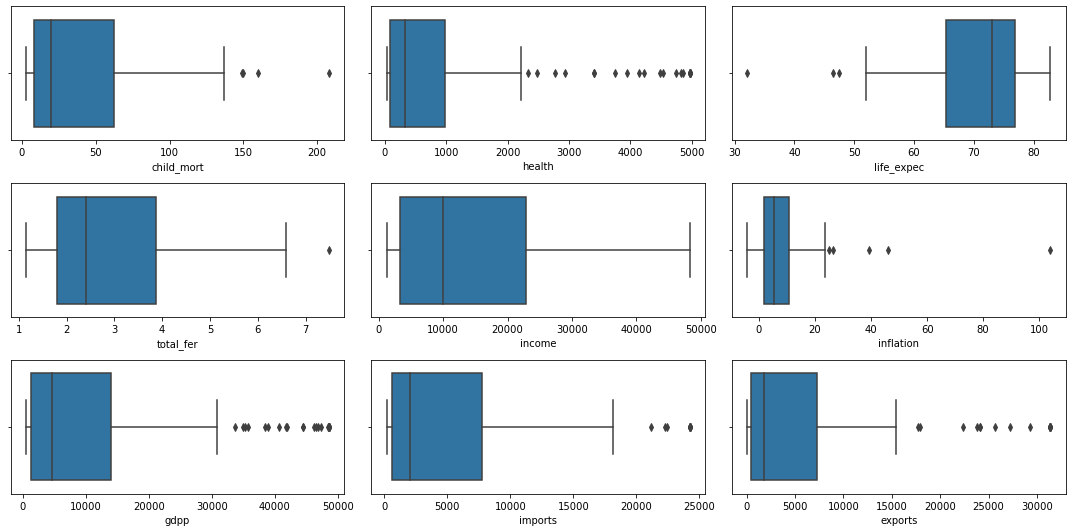

In [22]:
# Plot boxplot after capping to 5%-95%
fig, axs = plt.subplots(3,3, figsize = (15,7.5))

plt1 = sns.boxplot(country_details['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(country_details['health'], ax = axs[0,1])
plt3 = sns.boxplot(country_details['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(country_details['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(country_details['income'], ax = axs[1,1])
plt6 = sns.boxplot(country_details['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(country_details['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(country_details['imports'], ax = axs[2,1])
plt9 = sns.boxplot(country_details['exports'], ax = axs[2,2])

plt.tight_layout()

## Check the cluster tendancy: Hopkin's Test

In [23]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
hopkins(country_details.drop('country', axis=1))

0.805132485873568

In [25]:
# How different your data is from randomly scattered data
for i in range(20):
    print(hopkins(country_details.drop('country', axis=1)),end=' | ')

0.9130057029313278 | 0.8722603239332101 | 0.8489475560260268 | 0.8898442500470636 | 0.8655597271857169 | 0.8921603064893607 | 0.9219830957899697 | 0.9162026168341043 | 0.9567747552841338 | 0.9014128168181514 | 0.8963507652772813 | 0.8800678656581534 | 0.9034428879143441 | 0.9069338610779746 | 0.9137288738230871 | 0.8828136926816655 | 0.8902461594050729 | 0.8522250969040343 | 0.9003947155269756 | 0.9183692292336322 | 

### Hopkin's test says that our data is 82% different from the randomly scattered data.
### The higher the value of dissimilarity, the more apt is our data for clustering.

## Scaling

In [26]:
ss = StandardScaler()
df1 = ss.fit_transform(country_details.drop("country",axis=1))
df1

array([[ 1.29153238, -0.66803864, -0.62977844, ..., -1.61909203,
         1.90288227, -0.7578739 ],
       [-0.5389489 , -0.54238923, -0.47380714, ...,  0.64786643,
        -0.85997281, -0.52377507],
       [-0.27283273, -0.47604845, -0.53034406, ...,  0.67042323,
        -0.0384044 , -0.49928636],
       ...,
       [-0.37231541, -0.56600553, -0.59686482, ...,  0.28695762,
        -0.66120626, -0.70777132],
       [ 0.44841668, -0.63033074, -0.61187406, ..., -0.34463279,
         1.14094382, -0.70777132],
       [ 1.11495062, -0.61312123, -0.59935647, ..., -2.09278484,
         1.6246091 , -0.69784347]])

In [27]:
df1 = pd.DataFrame(df1)
df1.columns = cols
df1.head()

,child_mort,total_fer,inflation,life_expec,health,gdpp,income,exports,imports
0,1.291532,-0.668039,-0.629778,-0.733291,-0.960575,0.157336,-1.619092,1.902882,-0.757874
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.395590,-0.312347,0.647866,-0.859973,-0.523775
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.193907,0.789274,0.670423,-0.038404,-0.499286
3,2.007808,-0.419165,-0.589272,-0.543598,-0.669255,1.387054,-1.179234,2.128151,-0.560839
4,-0.695634,-0.027297,-0.150953,0.306143,0.227115,-0.601749,0.704258,-0.541946,0.012991


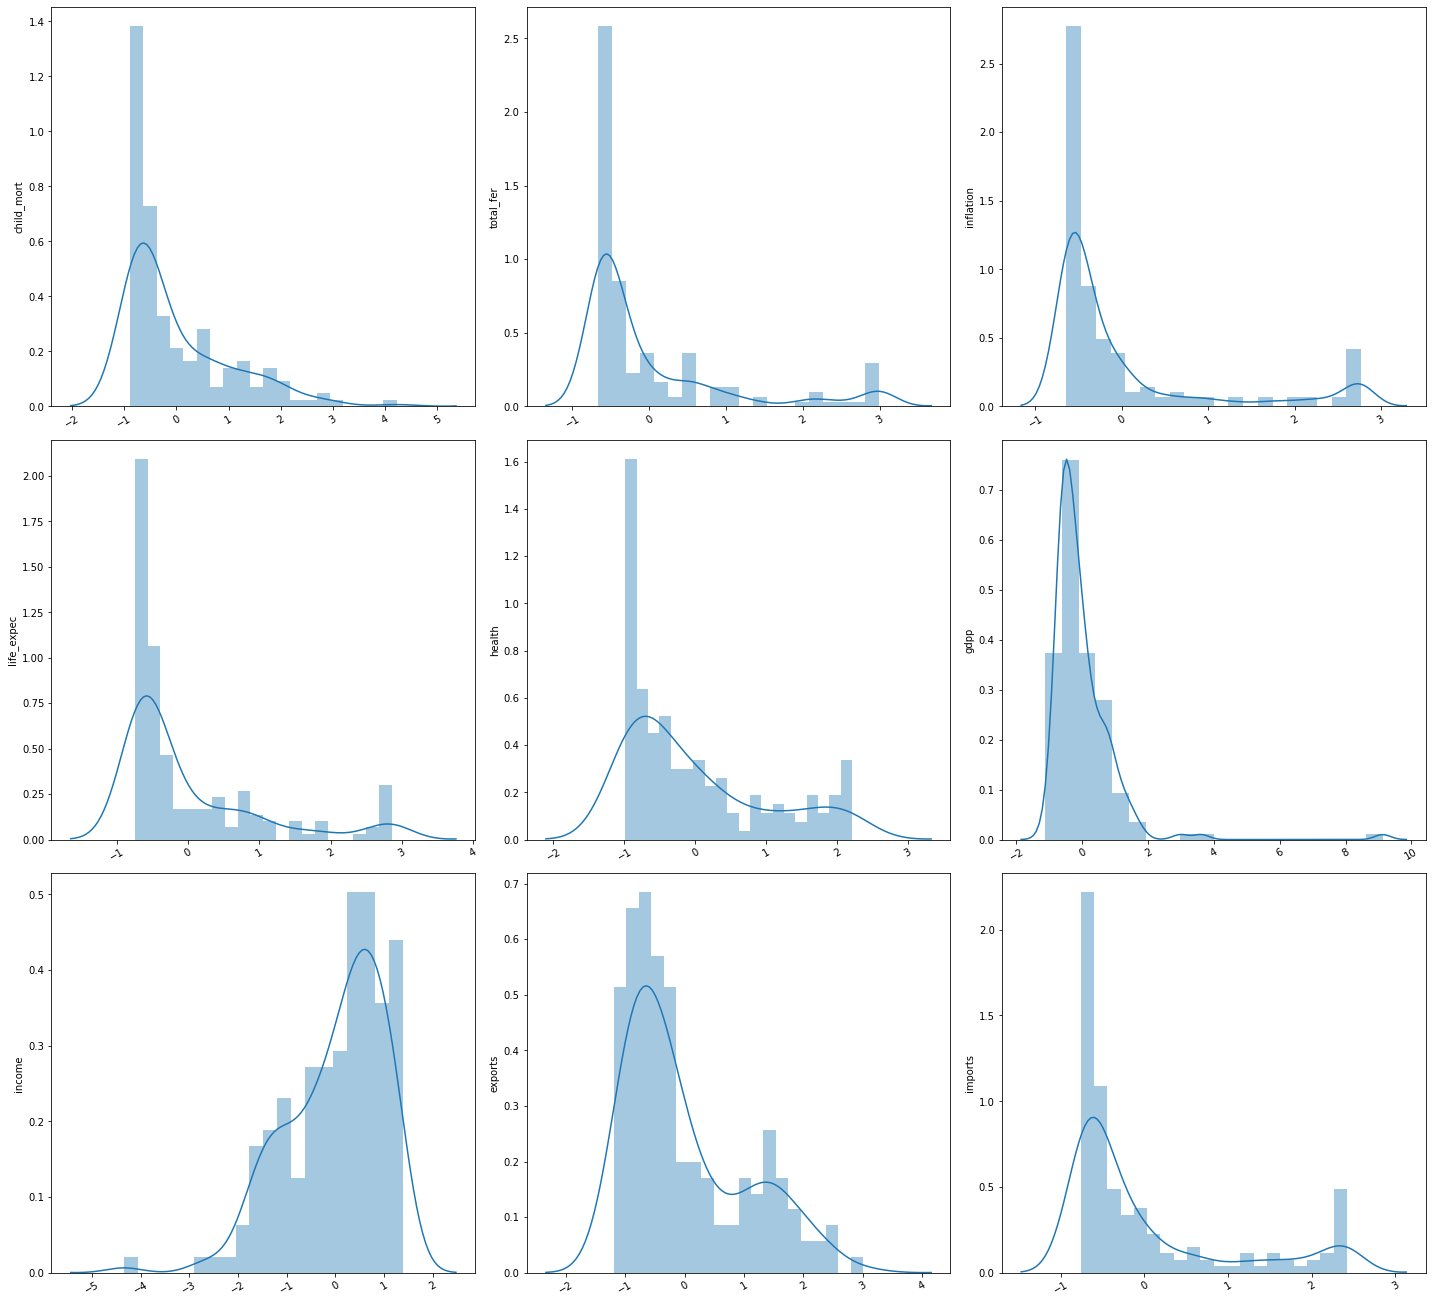

In [28]:
# After Sacling
# Find the countries with highest: Child Mortality Rate,Fertility Rate, Inflation
# Find the countries with lowest: Life Expectancy, Health, GDP,Income,Imports,Exports
cols=['child_mort','total_fer','inflation','life_expec','health','gdpp','income','exports','imports']

# Bin the data and plot the dist plot of the numerical terms
plt.figure(figsize=(20, 60))
i=1
sortAsc=False
for c in cols:
    ax2 = plt.subplot(10,3,i)
    if(i>3):
        sortAsc = True
    top10_df = df1.sort_values(c, ascending = sortAsc).head(20)
#     sns.barplot(x='country', y=c, data= top10_df, ax = ax2)
    sns.distplot(df1[c],bins = 20, ax=ax2)
    ax2.set(xlabel=None, ylabel=c)
    plt.xticks(rotation=30)
    i = i + 1

plt.tight_layout()
plt.show()

##### Conclusion:

- There is lot of variation in the mean values of the columns, because data in each col is measured in different units of measurement.
- We can see groups having 
- However most ML algorithms would consider income more important than child_mort only because the values for income are larger and have higher variability from country to country. As k-means algorithm computes the Euclidean distance between the data points, it is important to ensure that the attributes with a larger range of values do not out-weight the attributes with smaller range. This is because the ML algorithms internally use SVD to compute the principal components and assume that the data is scaled and centred. Hence Feature Scaling is required so that all the cols are brought down in same range so that they can be compared with each other.
- There are two common ways of rescaling:
    - Standardisation (mean-0, sigma-1)    
        - We have used StandardScaler class for this which implements standardization method to scale the numerical features. Standardization scales/shifts the values so that the features have a mean of 0 and standard deviation of 1.
    - Min-Max scaling(Normalization)
        - However we can also use MinMaxScaler.    

## Find the best value of k: SSD, Silhoutte Score

In [29]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2,11):
    kmean = KMeans(n_clusters=k).fit(df1)
    ss.append([k, silhouette_score(df1, kmean.labels_)])
    
ss

[[2, 0.49386557166579337],
 [3, 0.4348690395728478],
 [4, 0.40387931882030764],
 [5, 0.3745508892509409],
 [6, 0.3209979510988165],
 [7, 0.3006229029732674],
 [8, 0.3164507875935113],
 [9, 0.31101198446064116],
 [10, 0.3002191978592591]]

In [30]:
sil = pd.DataFrame(ss)
sil

,0,1
0,2,0.493866
1,3,0.434869
2,4,0.403879
3,5,0.374551
4,6,0.320998
5,7,0.300623
6,8,0.316451
7,9,0.311012
8,10,0.300219


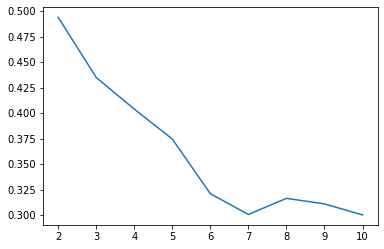

In [31]:
plt.plot(sil[0],sil[1]);

In [32]:
# SSD: Elbow

ssd = []
for k in range(2,11):
    kmean = KMeans(n_clusters=k).fit(df1)
    ssd.append([k, kmean.inertia_])
ssd

[[2, 767.1785063947434],
 [3, 488.25719332876696],
 [4, 409.01137403622715],
 [5, 330.485358160085],
 [6, 288.203534352602],
 [7, 260.58978060318327],
 [8, 231.01396642857964],
 [9, 204.5545988973977],
 [10, 191.9130735057905]]

In [33]:
ssd = pd.DataFrame(ssd)
ssd

,0,1
0,2,767.178506
1,3,488.257193
2,4,409.011374
3,5,330.485358
4,6,288.203534
5,7,260.589781
6,8,231.013966
7,9,204.554599
8,10,191.913074


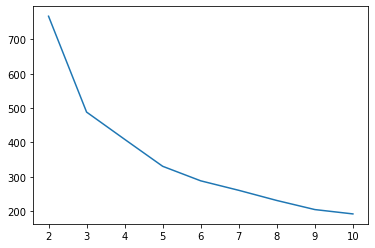

In [34]:
plt.plot(ssd[0],ssd[1]);

## By looking Silhouette analysis, we see the highest peak is at k = 2 and in sum of squared distances graph, we see that the comfortable elbow value is at 3. Hence Final KMeans with K = 3.

## Using the final value of k, perform final KMeans Analysis

In [35]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df1)

KMeans(n_clusters=3, random_state=0)

In [36]:
# Centroids
kmeans.cluster_centers_

array([[ 1.39941582, -0.58348529, -0.59725263, -0.66014586, -0.84073166,
         0.39995869, -1.27848434,  1.42716765, -0.68515184],
       [-0.38325851, -0.35247378, -0.38429418, -0.33898911, -0.23346099,
         0.00276089,  0.21530661, -0.41169578, -0.37890469],
       [-0.82153348,  1.51938134,  1.60922631,  1.58163887,  1.55884077,
        -0.49277884,  1.06029009, -0.78995685,  1.70374949]])

In [37]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [38]:
# Now we will assign labels to our original df
country_details['labels'] = kmeans.labels_

In [39]:
country_details.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


In [40]:
country_details['labels'].value_counts()

1    85
0    45
2    37
Name: labels, dtype: int64

## Visualize the cluster using a scatter plots

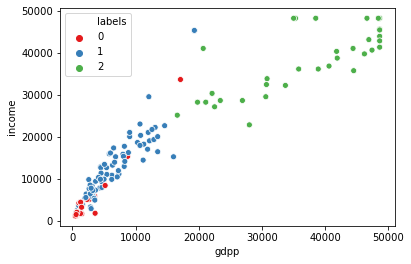

In [41]:
sns.scatterplot(x='gdpp', y='income', hue='labels', data= country_details, palette='Set1');

## Scatter plot of income, gdpp for 3 cluster. We can see that cluster 0, both gdpp and income per person is very low


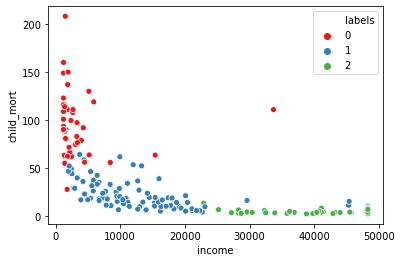

In [42]:
sns.scatterplot(x='income', y='child_mort', hue='labels', data= country_details, palette='Set1');

## Scatter plot of income, child mort for 3 cluster. We can see that cluster 0 income is very low and child mort is high.

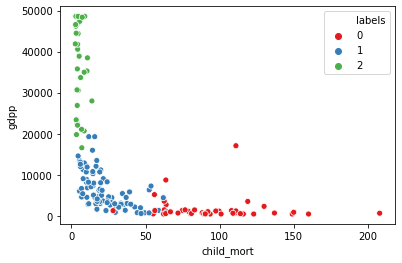

In [43]:
sns.scatterplot(x='child_mort', y='gdpp', hue='labels', data= country_details, palette='Set1');

## Scatter plot of child mort, gdpp for 3 cluster. We can see that cluster 0 gdpp is low and child mort is high.

## Cluster Profiling

### Find one such cluster that is having LOW GDPP, LOW INCOME and HIGH CHILD_MORT.

In [44]:
country_details[['income','child_mort','gdpp','labels']].groupby('labels').mean()

,income,child_mort,gdpp
labels,,,
0,3374.822222,94.537778,1651.757778
1,12317.529412,22.860000,6278.847059
2,38711.081081,5.237838,37745.675676


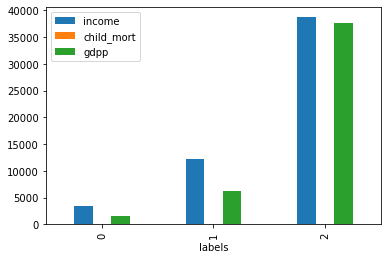

In [45]:
country_details[['income','child_mort','gdpp','labels']].groupby('labels').mean().plot(kind='bar');

## As per K Mean Clusters, Cluster 0 is area of concern as Low income (3374.82), High Child mort (94.53) and low gdpp (1651.75)

## Identifying the countries once you have identified the cluster


In [46]:
c1 = country_details[country_details['labels']==0]
c1

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,70.4688,41.91740,248.297,1610.0,9.440,56.2,5.82,553.0,0
3,Angola,119.0,2199.1900,100.60500,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
17,Benin,111.0,180.4040,31.07800,281.976,1820.0,0.885,61.8,5.36,758.0,0
25,Burkina Faso,116.0,110.4000,38.75500,170.200,1430.0,6.810,57.9,5.87,575.0,0
26,Burundi,93.6,70.4688,26.79600,169.281,1213.0,12.300,57.7,6.26,465.9,0
28,Cameroon,108.0,290.8200,67.20300,353.700,2660.0,1.910,57.3,5.11,1310.0,0
31,Central African Republic,149.0,70.4688,26.71592,169.281,1213.0,2.010,47.5,5.21,465.9,0
32,Chad,150.0,330.0960,40.63410,390.195,1930.0,6.390,56.5,6.59,897.0,0
36,Comoros,88.2,126.8850,34.68190,397.573,1410.0,3.870,65.9,4.75,769.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.71592,169.281,1213.0,20.800,57.5,6.54,465.9,0


In [47]:
c1.sort_values(by=['gdpp','child_mort','income'], ascending=[True, False, True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
132,Sierra Leone,160.0,70.4688,52.26900,169.281,1220.0,17.20,55.0,5.20,465.9,0
31,Central African Republic,149.0,70.4688,26.71592,169.281,1213.0,2.01,47.5,5.21,465.9,0
112,Niger,123.0,77.2560,26.71592,170.868,1213.0,2.55,58.8,7.49,465.9,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.71592,169.281,1213.0,20.80,57.5,6.54,465.9,0
106,Mozambique,101.0,131.9850,26.71592,193.578,1213.0,7.64,54.5,5.56,465.9,0
26,Burundi,93.6,70.4688,26.79600,169.281,1213.0,12.30,57.7,6.26,465.9,0
94,Malawi,90.5,104.6520,30.24810,169.281,1213.0,12.10,53.1,5.31,465.9,0
88,Liberia,89.3,70.4688,38.58600,302.802,1213.0,5.47,60.8,5.02,465.9,0
93,Madagascar,62.2,103.2500,26.71592,177.590,1390.0,8.79,60.8,4.60,465.9,0
50,Eritrea,55.2,70.4688,26.71592,169.281,1420.0,11.60,61.7,4.61,482.0,0


##### Conclusion:
### We have identified the list of below 10 countries which are in direst need of aid:  
 ### 1. Sierra Leone
 ### 2. Central African Republic
 ### 3. Niger
 ### 4. Congo, Dem. Rep
 ### 5. Mozambique
 ### 6. Burundi  
 ### 7. Malawi  
 ### 8. Liberia  
 ### 9. Madagascar
 ### 10.Eritrea

## Hierarchial Clustering

In [48]:
df1.head()

,child_mort,total_fer,inflation,life_expec,health,gdpp,income,exports,imports
0,1.291532,-0.668039,-0.629778,-0.733291,-0.960575,0.157336,-1.619092,1.902882,-0.757874
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.395590,-0.312347,0.647866,-0.859973,-0.523775
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.193907,0.789274,0.670423,-0.038404,-0.499286
3,2.007808,-0.419165,-0.589272,-0.543598,-0.669255,1.387054,-1.179234,2.128151,-0.560839
4,-0.695634,-0.027297,-0.150953,0.306143,0.227115,-0.601749,0.704258,-0.541946,0.012991


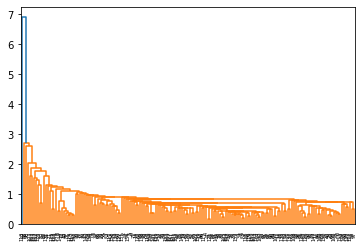

In [49]:
# single linkage
mergings = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

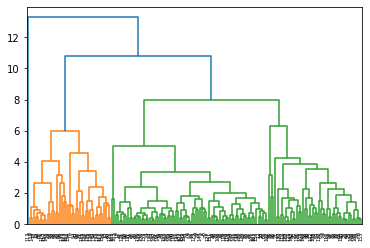

In [50]:
# complete linkage
mergings = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

## We are going to use this method as Single linkage is not clear. By looking at Dendrogram taking n-cluster as 3

In [51]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [52]:
# assign cluster labels
df1['cluster_labels'] = cluster_labels
df1.head()

,child_mort,total_fer,inflation,life_expec,health,gdpp,income,exports,imports,cluster_labels
0,1.291532,-0.668039,-0.629778,-0.733291,-0.960575,0.157336,-1.619092,1.902882,-0.757874,0
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.395590,-0.312347,0.647866,-0.859973,-0.523775,0
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.193907,0.789274,0.670423,-0.038404,-0.499286,0
3,2.007808,-0.419165,-0.589272,-0.543598,-0.669255,1.387054,-1.179234,2.128151,-0.560839,0
4,-0.695634,-0.027297,-0.150953,0.306143,0.227115,-0.601749,0.704258,-0.541946,0.012991,0


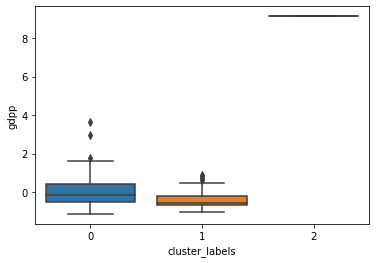

In [53]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=df1)

## Box plot of gdpp and cluster labels for n-cluster as 3, we can see that cluster 0 Q3 is higher than other clusters. 


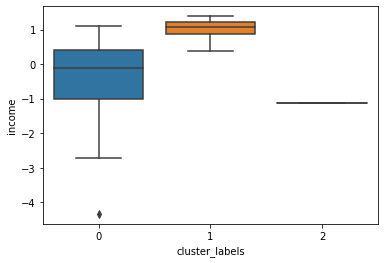

In [54]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=df1)

## Box plot of income and labels for n-cluster as 3, we can see that cluster 0 low income compare to cluster 1 

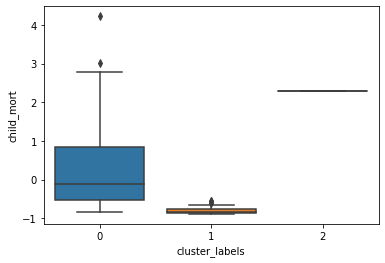

In [55]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=df1)

## Box plot of child mort and labels for n-cluster as 3, we can see that cluster 0 is high in child mort as compare to other clusters.


In [56]:
# 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 3, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [57]:
# assign cluster labels
df1['cluster_labels'] = cluster_labels
df1.head()

,child_mort,total_fer,inflation,life_expec,health,gdpp,income,exports,imports,cluster_labels
0,1.291532,-0.668039,-0.629778,-0.733291,-0.960575,0.157336,-1.619092,1.902882,-0.757874,0
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.395590,-0.312347,0.647866,-0.859973,-0.523775,1
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.193907,0.789274,0.670423,-0.038404,-0.499286,1
3,2.007808,-0.419165,-0.589272,-0.543598,-0.669255,1.387054,-1.179234,2.128151,-0.560839,0
4,-0.695634,-0.027297,-0.150953,0.306143,0.227115,-0.601749,0.704258,-0.541946,0.012991,1


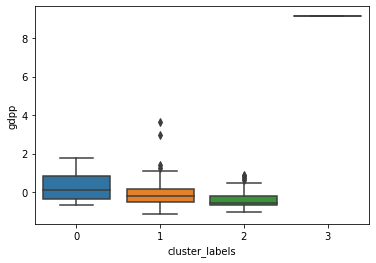

In [58]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=df1)

## Box plot of gdpp and lables for n-cluster as 4, we can see that cluster 2 have low gdpp compare to others clusters. Its also observed there are some outliers in cluster 1. 


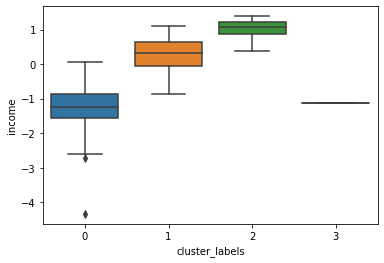

In [59]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=df1)

## Box plot of income and label n-cluster as 4, we can cluster 0 have low income as compare to other clusters.


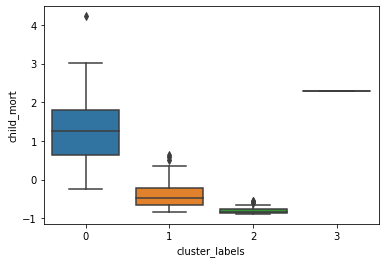

In [60]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=df1)

## Box plot of child mort and label n-cluster as 4, we can child mort is high in cluster 0 as compare to other clusters.


### Summary:

## We use the clusters formed during K-means clustering to find the countries and got Cluster 0 which is having LOW GDPP, LOW INCOME and HIGH CHILD_MORT.
## The following are the countries which are in direst need of aid by considering socio – economics factor into consideration:
 ### 1. Sierra Leone
 ### 2. Central African Republic
 ### 3. Niger
 ### 4. Congo, Dem. Rep
 ### 5. Mozambique
 ### 6. Burundi  
 ### 7. Malawi  
 ### 8. Liberia  
 ### 9. Madagascar
 ### 10.Eritrea